<a href="https://colab.research.google.com/github/RhettDelFierro/Capstone_Colab/blob/main/Copy_of_Untitled0_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install anvil-uplink

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor
import ipywidgets as widgets
from IPython.display import display
from io import BytesIO
import anvil.server
anvil.server.connect("server_KKLI2RHI3JI6523WK7QA4OFU-ZMKP3JIS4D2XCZ44")
import anvil.media
import anvil.mpl_util
import os
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'WGU_colab')
drive.mount(MOUNTPOINT)

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load data.

In [ ]:
data = pd.read_csv(os.path.join(DATADIR,"./[pruned fine][ready]combined_games_with_corrected_travel_and_last_game.csv"))
print(data.sample(10).to_markdown())

|     |   Week | Home Team             | Away Team            |   Point Differential | Favorite             |   Line | Roof                      | Turf       |   Degrees |   Humidity |   Wind |   PreseasonRankingHome |   PreseasonRankingAway |   HomeEndOfSeasonRanking |   AwayEndOfSeasonRanking |   DistanceTravelledByAwayTeam | LastGameAway   | NextGameAway   |
|----:|-------:|:----------------------|:---------------------|---------------------:|:---------------------|-------:|:--------------------------|:-----------|----------:|-----------:|-------:|-----------------------:|-----------------------:|-------------------------:|-------------------------:|------------------------------:|:---------------|:---------------|
|  23 |     16 | Cleveland Browns      | Baltimore Ravens     |                  -16 | Baltimore Ravens     |   -9.5 | outdoors                  | grass      |        49 |         41 |     10 |                     13 |                     17 |                       22 |  

Handle missing values for 'Degrees', 'Humidity', and 'Wind'

In [ ]:
# Preprocess the data
for column, value in zip(['Degrees', 'Humidity', 'Wind'], [68, 40, 0]):
    data.loc[(data[column].isna()) & ((data['Roof'] == 'outdoors') | (data['Roof'] == 'retractable roof (open)')), column] = data[column].mean()
    data.loc[(data[column].isna()), column] = value
data['Line'].fillna(0.0, inplace=True)
data['Favorite'].fillna('pick', inplace=True)
data['Turf'] = data['Turf'].apply(lambda x: 'turf' if x != 'grass' else 'grass')


### Identify numerical and categorical columns, then process them.

In [ ]:
# Prepare for one-hot encoding
categorical_features = ['Home Team', 'Away Team', 'Turf', 'Favorite', 'Roof', 'LastGameAway', 'NextGameAway']
numeric_features = data.drop(columns=categorical_features+['Point Differential']).columns.tolist()

# Construct preprocessing pipelines
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations
X = data.drop(columns=['Point Differential'])
y = data['Point Differential']
X = preprocessor.fit_transform(X)



### Apply machine learning training and testing.

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Save the trained model and preprocessing pipeline
dump(model, 'model.joblib')
dump(preprocessor, 'preprocessor.joblib')

['preprocessor.joblib']

Plot graphs.

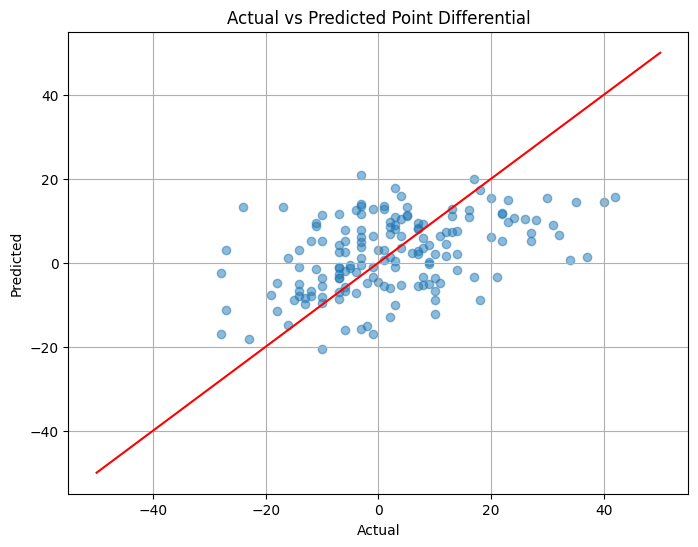

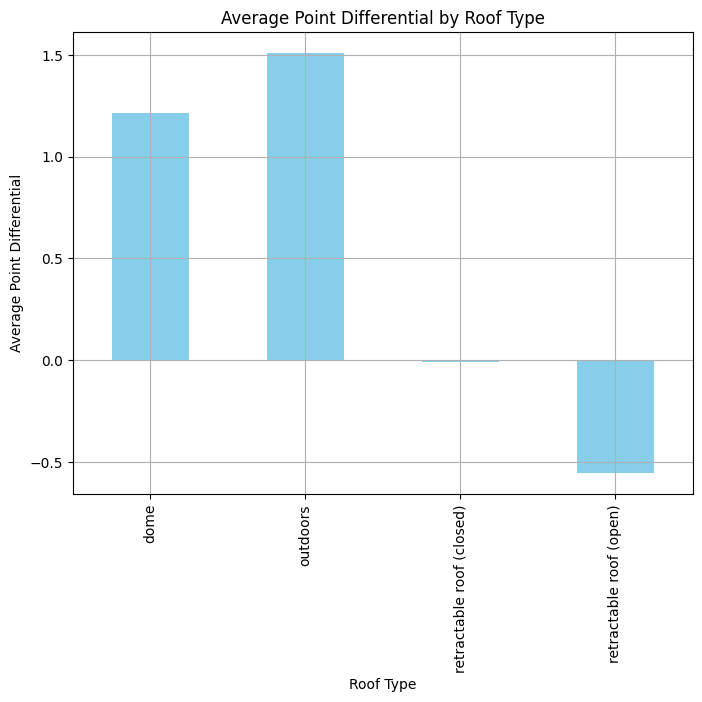

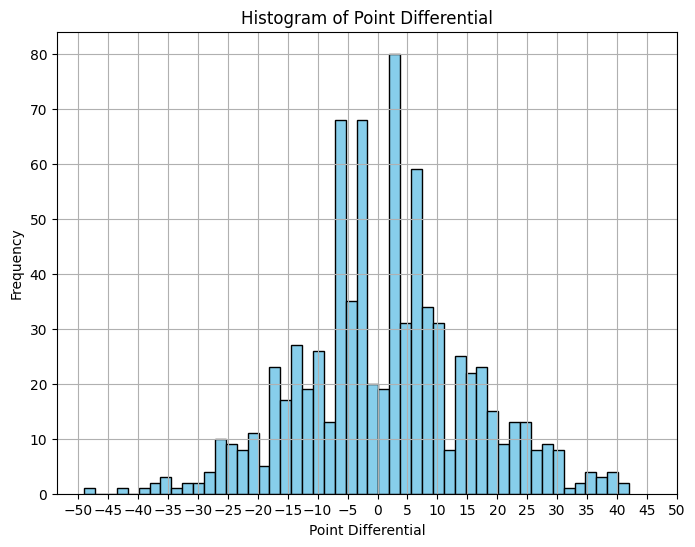

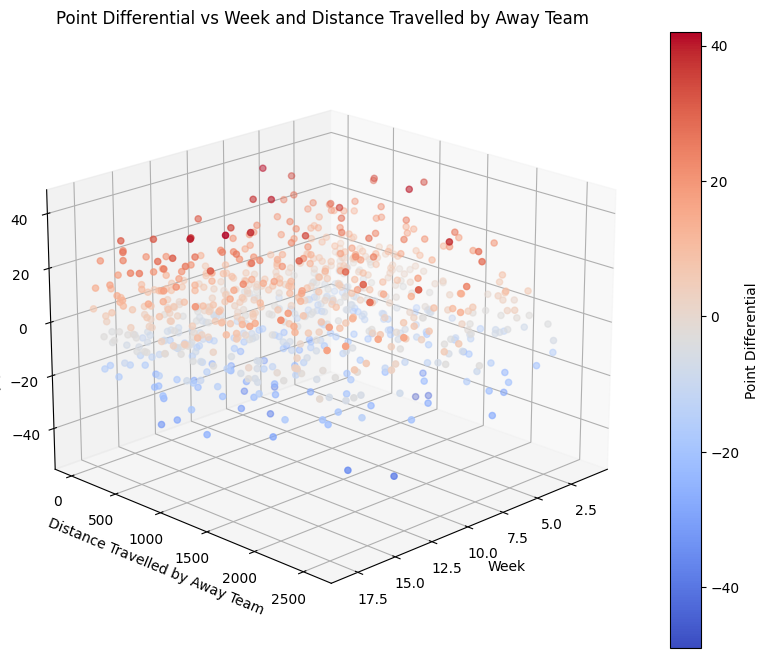

In [ ]:
# Scatter plot of actual vs predicted values
y_pred_test = model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([-50, 50], [-50, 50], color='red')  # Line where predicted = actual
plt.title('Actual vs Predicted Point Differential')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()

# Bar plot of Average Point Differential by Roof Type
avg_diff_by_roof = data.groupby('Roof')['Point Differential'].mean()
plt.figure(figsize=(8, 6))
avg_diff_by_roof.plot(kind='bar', color='skyblue')
plt.title('Average Point Differential by Roof Type')
plt.xlabel('Roof Type')
plt.ylabel('Average Point Differential')
plt.grid(True)
plt.show()

# Histogram of 'Point Differential'
plt.figure(figsize=(8, 6))
plt.hist(data['Point Differential'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Point Differential')
plt.xlabel('Point Differential')
plt.ylabel('Frequency')
x_labels = np.arange(-50, 51, 5)  # creates an array from -50 to 50 with a step of 5
plt.xticks(x_labels)
plt.grid(True)
plt.show()

# 3D scatter plot of 'Point Differential', 'Week', and 'DistanceTravelledByAwayTeam'
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data['Week'], data['DistanceTravelledByAwayTeam'], data['Point Differential'],
                     c=data['Point Differential'], cmap='coolwarm')
ax.set_title('Point Differential vs Week and Distance Travelled by Away Team')
ax.set_xlabel('Week')
ax.set_ylabel('Distance Travelled by Away Team')
ax.set_zlabel('Point Differential')
# Set the viewing angle
ax.view_init(elev=20, azim=45)
plt.colorbar(scatter, label='Point Differential')
plt.show()


Function to use as an interface.

In [ ]:
def predict_point_differential(features_df):
    """
    Predict the point differential for a game.

    Args:
    features_df (pd.DataFrame): A DataFrame with the same structure as the original data, excluding the 'Point Differential' column.

    Returns:
    float: The predicted point differential.
    """
    # Load the trained model and preprocessing pipeline
    model = load('model.joblib')
    preprocessor = load('preprocessor.joblib')

    # Preprocess the input in the same way as the training data
    features_df['Turf'] = features_df['Turf'].apply(lambda x: 'turf' if x != 'grass' else 'grass')
    for column, value in zip(['Degrees', 'Humidity', 'Wind'], [68, 40, 0]):
        features_df.loc[(features_df[column].isna()) & ((features_df['Roof'] == 'outdoors') | (features_df['Roof'] == 'retractable roof (open)')), column] = data[column].mean()
        features_df.loc[(features_df[column].isna()), column] = value
    features_df['Line'].fillna(0.0, inplace=True)
    features_df['Favorite'].fillna('pick', inplace=True)
    features_transformed = preprocessor.transform(features_df)

    # Use the trained model to make a prediction
    prediction = model.predict(features_transformed)

    return prediction[0]

@anvil.server.callable
def make_plot_actual_predict():
  # Scatter plot of actual vs predicted values
  y_pred_test = model.predict(X_test)
  plt.figure(figsize=(5, 4))
  plt.scatter(y_test, y_pred_test, alpha=0.5)
  plt.plot([-50, 50], [-50, 50], color='red')  # Line where predicted = actual
  plt.title('Actual vs Predicted Point Differential')
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.grid(True)
  # plt.show()

  # bytes_image = BytesIO()
  # plt.savefig(bytes_image, format='png')
  # bytes_image.seek(0)
  print('are we running new code3')
  return anvil.mpl_util.plot_image()
  # return anvil.BlobMedia('image/png', bytes_image.read(), name='plot.png')

@anvil.server.callable
def make_plot_point_differential():
  # Histogram of 'Point Differential'
  plt.figure(figsize=(5, 4))
  plt.hist(data['Point Differential'], bins=50, color='skyblue', edgecolor='black')
  plt.title('Histogram of Point Differential')
  plt.xlabel('Point Differential')
  plt.ylabel('Frequency')
  x_labels = np.arange(-50, 51, 5)  # creates an array from -50 to 50 with a step of 5
  plt.xticks(x_labels)
  plt.grid(True)
  # plt.show()
  return anvil.mpl_util.plot_image()
  # return anvil.BlobMedia('image/png', bytes_image.read(), name='plot.png')

@anvil.server.callable
def make_plot_3d():
  # 3D scatter plot of 'Point Differential', 'Week', and 'DistanceTravelledByAwayTeam'
  fig = plt.figure(figsize=(5, 4))
  ax = fig.add_subplot(111, projection='3d')
  scatter = ax.scatter(data['Week'], data['DistanceTravelledByAwayTeam'], data['Point Differential'],
                      c=data['Point Differential'], cmap='coolwarm')
  ax.set_title('Point Differential vs Week and Distance Travelled by Away Team')
  ax.set_xlabel('Week')
  ax.set_ylabel('Distance Travelled by Away Team')
  ax.set_zlabel('Point Differential')
  # Set the viewing angle
  ax.view_init(elev=20, azim=45)
  plt.colorbar(scatter, label='Point Differential')
  # plt.show()
  return anvil.mpl_util.plot_image()
  # return anvil.BlobMedia('image/png', bytes_image.read(), name='plot.png')

@anvil.server.callable
def predict(week,
            home_team_dropdown,
            away_team_dropdown,
            favorite_dropdown,
            line_input,
            roof_dropdown,
            turf_dropdown,
            degrees_text,
            humidity_text,
            wind_text,
            preseason_rank_home_dropdown,
            preseason_rank_away_dropdown,
            current_rank_home_dropdown,
            current_rank_away_dropdown,
            distance_text,
            last_game_away_dropdown,
            next_game_away_dropdown
            ):
  print(degrees_text)
  print(last_game_away_dropdown)
  features_df = pd.DataFrame({
      'Week': [week],
      'Home Team': [home_team_dropdown],
      'Away Team': [away_team_dropdown],
      'Favorite': [favorite_dropdown],
      'Line': [line_input],
      'Roof': [roof_dropdown],
      'Turf': [turf_dropdown],
      'Degrees': [degrees_text],
      'Humidity': [humidity_text],
      'Wind': [wind_text],
      'PreseasonRankingHome': [preseason_rank_home_dropdown],
      'PreseasonRankingAway': [preseason_rank_away_dropdown],
      'HomeEndOfSeasonRanking': [current_rank_home_dropdown],
      'AwayEndOfSeasonRanking': [current_rank_away_dropdown],
      'DistanceTravelledByAwayTeam': [distance_text],
      'LastGameAway': [last_game_away_dropdown],
      'NextGameAway': [next_game_away_dropdown],
  }, index=[0])



  prediction = predict_point_differential(features_df)
  print('Predicted point differential 2:', prediction)
  return prediction




### Interaction

In [ ]:
anvil.server.wait_forever()